In [2]:
#Import libraries
import nibabel as nib
import numpy as np
import os
from skimage.transform import resize
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import numpy as np
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchviz
import torchvision.models as models



In [ ]:
#First step of preprocessing: Removing all empty slices

# Base directory where all cases are stored
base_directory = "C:\\Users\\zladi\\Downloads\\kits23-v0.1.2 - Copy\\kits23-v0.1.2\\kits23\\dataset"

# Directory to save the modified NIfTI files
output_dir = "C:\\Users\\zladi\\Downloads\\kits23-v0.1.2 - Copy\\kits23-v0.1.2\\kits23\\all_cases_modified"
os.makedirs(output_dir, exist_ok=True)

for case_number in range(1,599):  # Since Python ranges are exclusive at the top end
    case_id = f"case_{case_number:05d}"  # Formats the number as 5 digits with leading zeros
    case_path = os.path.join(base_directory, case_id)

    # Check if the case directory exists
    if os.path.exists(case_path):
        imaging_path = os.path.join(case_path, "imaging.nii.gz")
        segmentation_path = os.path.join(case_path, "segmentation.nii.gz")

        # Perform the checks and processing only if both files exist
        if os.path.isfile(imaging_path) and os.path.isfile(segmentation_path):
            imaging_nii = nib.load(imaging_path)
            segmentation_nii = nib.load(segmentation_path)

            imaging_data = imaging_nii.get_fdata()
            segmentation_data = segmentation_nii.get_fdata()

            # Ensure the width and height are the same for imaging and segmentation data
            assert imaging_data.shape[1] == imaging_data.shape[2], f"Width and height do not match for imaging data of {case_id}"
            assert segmentation_data.shape[1] == segmentation_data.shape[2], f"Width and height do not match for segmentation data of {case_id}"

            segmented_slices = np.any(segmentation_data, axis=(1, 2))

            imaging_data_filtered = imaging_data[segmented_slices, :, :]
            segmentation_data_filtered = segmentation_data[segmented_slices, :, :]

            imaging_nii_filtered = nib.Nifti1Image(imaging_data_filtered, imaging_nii.affine, imaging_nii.header)
            segmentation_nii_filtered = nib.Nifti1Image(segmentation_data_filtered, segmentation_nii.affine, segmentation_nii.header)

            filtered_imaging_path = os.path.join(output_dir, f"{case_id}_imaging_filtered.nii.gz")
            filtered_segmentation_path = os.path.join(output_dir, f"{case_id}_segmentation_filtered.nii.gz")

            nib.save(imaging_nii_filtered, filtered_imaging_path)
            nib.save(segmentation_nii_filtered, filtered_segmentation_path)

            print(f"Processed {case_id}")
        else:
            print(f"Skipping {case_id}: missing imaging or segmentation file.")
    else:
        print(f"Case directory does not exist: {case_id}")


In [ ]:
#Second Step of Preprocessing: Reducing the Resolution
# Load the imaging and segmentation files
imaging_path = r"C:\Users\ganess4\Desktop\kits23\dataset\case_00002\imaging.nii.gz"
segmentation_path = r"C:\Users\ganess4\Desktop\kits23\dataset\case_00002\segmentation.nii.gz"

imaging_nii = nib.load(imaging_path)
segmentation_nii = nib.load(segmentation_path)

# Extract the data arrays
imaging_data = imaging_nii.get_fdata()
segmentation_data = segmentation_nii.get_fdata()

# Check the shape and print it for debugging purposes
print("Imaging shape:", imaging_data.shape)
print("Segmentation shape:", segmentation_data.shape)

# Ensure the width and height are the same for imaging and segmentation data
assert imaging_data.shape[1] == imaging_data.shape[2], "Width and height do not match for imaging data"
assert segmentation_data.shape[1] == segmentation_data.shape[2], "Width and height do not match for segmentation data"

# Find indices of slices with segmentation (non-zero pixels)
# The first dimension is assumed to be the slice dimension
segmented_slices = np.any(segmentation_data, axis=(1, 2))

# Filter out slices without segmentation from both imaging and segmentation data
imaging_data_filtered = imaging_data[segmented_slices, :, :]
segmentation_data_filtered = segmentation_data[segmented_slices, :, :]

# Reduce resolution to 128x128
imaging_data_resized = np.zeros((imaging_data_filtered.shape[0], 128, 128))
segmentation_data_resized = np.zeros((segmentation_data_filtered.shape[0], 128, 128))

for i in range(imaging_data_filtered.shape[0]):
    imaging_data_resized[i] = resize(imaging_data_filtered[i], (128, 128), anti_aliasing=True)
    segmentation_data_resized[i] = resize(segmentation_data_filtered[i], (128, 128), anti_aliasing=False)

# Create new NIfTI objects for the resized data
imaging_nii_resized = nib.Nifti1Image(imaging_data_resized, imaging_nii.affine)
segmentation_nii_resized = nib.Nifti1Image(segmentation_data_resized, segmentation_nii.affine)

# Define paths for the new resized files
output_dir = r"C:\Users\ganess4\Desktop\kits23\processed_data_1"
os.makedirs(output_dir, exist_ok=True)

resized_imaging_path = os.path.join(output_dir, 'case_00002_imaging_filtered.nii.gz')
resized_segmentation_path = os.path.join(output_dir, 'case_00002_segmentation_filtered.nii.gz')

print("Resized Imaging shape:", imaging_data_resized.shape)
print("Resized Segmentation shape:", segmentation_data_resized.shape)

# Save the resized NIfTI files
nib.save(imaging_nii_resized, resized_imaging_path)
nib.save(segmentation_nii_resized, resized_segmentation_path)

In [2]:
#Data Loader Code. 1-300 for training, 401-457 for testing. This is for training

class SliceDataset(Dataset):
    def __init__(self, data_folder, cases, max_slices=200, transform=None):
        self.data_folder = Path(data_folder)
        self.transform = transform
        self.all_slices = []
        self.all_segs = []

        for case in cases:
            ct_scan_path = self.data_folder / f"{case}_imaging_filtered.nii.gz"
            seg_mask_path = self.data_folder / f"{case}_segmentation_filtered.nii.gz"

            if ct_scan_path.is_file() and seg_mask_path.is_file():
                ct_scan_volume = nib.load(str(ct_scan_path)).get_fdata()
                seg_mask_volume = nib.load(str(seg_mask_path)).get_fdata()
                
                # Use the minimum number of slices to avoid out-of-bounds indexing
                min_slices = min(ct_scan_volume.shape[0], seg_mask_volume.shape[0])
                slice_indices = np.linspace(0, min_slices - 1, min(max_slices, min_slices), dtype=int)

                for slice_idx in slice_indices:
                    ct_slice = ct_scan_volume[slice_idx, ...]
                    mask_slice = seg_mask_volume[slice_idx, ...]

                    self.all_slices.append(ct_slice)
                    self.all_segs.append(mask_slice)

    def __len__(self):
        return len(self.all_slices)

    def __getitem__(self, idx):
        ct_slice = self.all_slices[idx]
        mask_slice = self.all_segs[idx]

        ct_slice = np.expand_dims(ct_slice, axis=0).astype(np.float32)
        mask_slice = np.expand_dims(mask_slice, axis=0).astype(np.float32)

        if self.transform:
            ct_slice = self.transform(ct_slice)
            mask_slice = self.transform(mask_slice)

        return torch.from_numpy(ct_slice), torch.from_numpy(mask_slice)

    # Example setup
data_folder = "C:\\Users\\zladi\\Downloads\\kits23-v0.1.2 - Copy\\kits23-v0.1.2\\kits23\\preprocessandresize - Copy"
cases = ["case_{:05d}".format(i) for i in range(1, 300)]  # Example: Load first 50 cases
dataset = SliceDataset(data_folder, cases)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
print('Dataset size:', len(dataset))
print('Number of slices in dataset:', len(dataset.all_slices))

Dataset size: 20837
Number of slices in dataset: 20837


In [4]:
#Defining out UNet Model

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_classes=3, dropout_rate=0.2):
        super(UNet, self).__init__()

        # Contracting Path with Batch Normalization and Dropout
        self.conv1 = self.conv_stage(in_channels, 64, dropout_rate)  # Conv stage with 64 filters
        self.conv2 = self.conv_stage(64, 128, dropout_rate)  # Conv stage with 128 filters
        self.conv3 = self.conv_stage(128, 256, dropout_rate)  # Conv stage with 256 filters
        self.conv4 = self.conv_stage(256, 512, dropout_rate)  # Conv stage with 512 filters
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max-pooling with 2x2 kernel and stride 2

        # Bottleneck with Dropout and Batch Normalization
        self.bottleneck = self.conv_stage(512, 1024, dropout_rate)  # Bottleneck with 1024 filters
        
        # Expansive Path with Batch Normalization and Dropout
        self.upconv4 = self.upconv_stage(1024, 512)  # Upconv stage for expansive path
        self.upconv3 = self.upconv_stage(512, 256)
        self.upconv2 = self.upconv_stage(256, 128)
        self.upconv1 = self.upconv_stage(128, 64)
        
        # Fixing skip connections with Conv stage
        self.fix1 = self.conv_stage(1024, 512, dropout_rate)  # Skip connection fix stage
        self.fix2 = self.conv_stage(512, 256, dropout_rate)
        self.fix3 = self.conv_stage(256, 128, dropout_rate)
        self.fix4 = self.conv_stage(128, 64, dropout_rate)

        # Output layer for segmentation
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)  # Final output for segmentation
    
    def conv_stage(self, in_channels, out_channels, dropout_rate):
        """Convolutional stage with batch normalization and dropout"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),  # Dropout
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Convolutional layer
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),  # Dropout
        )
        
    def upconv_stage(self, in_channels, out_channels):
        """Upconvolution stage with batch normalization"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),  # Transpose convolution
            nn.BatchNorm2d(out_channels),  # Batch normalization after upconv
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        # Contracting path with max-pooling
        c1 = self.conv1(x)  # First conv stage
        p1 = self.pool(c1)  # Max-pooling
        c2 = self.conv2(p1)  # Second conv stage
        p2 = self.pool(c2)  # Max-pooling
        c3 = self.conv3(p2)  # Third conv stage
        p3 = self.pool(c3)  # Max-pooling
        c4 = self.conv4(p3)  # Fourth conv stage
        p4 = self.pool(c4)  # Max-pooling
    
        # Bottleneck
        b = self.bottleneck(p4)  # Bottleneck with dropout and batch normalization
    
        # Expansive path with skip connections
        u4 = self.upconv4(b)  # Upconv and concatenation
        u4 = u4[:, :, :c4.size(2), :c4.size(3)]  # Match dimensions with skip connection
        u4 = torch.cat((c4, u4), dim=1)  # Concatenate with corresponding contracting path
        u3 = self.fix1(u4)  # Fix stage with conv
    
        u3 = self.upconv3(u3)  # Next upconv
        u3 = u3[:, :, :c3.size(2), :c3.size(3)]  # Match dimensions
        u3 = torch.cat((c3, u3), dim=1)  # Concatenate with corresponding contracting path
        u2 = self.fix2(u3)  # Fix stage with conv
    
        u2 = self.upconv2(u2)  # Next upconv
        u2 = u2[:, :, :c2.size(2), :c2.size(3)]  # Match dimensions
        u2 = torch.cat((c2, u2), dim=1)  # Concatenate with corresponding contracting path
        u1 = self.fix3(u2)  # Fix stage with conv
    
        u1 = self.upconv1(u1)  # Next upconv
        u1 = u1[:, :, :c1.size(2), :c1.size(3)]  # Match dimensions
        u1 = torch.cat((c1, u1), dim=1)  # Concatenate with corresponding contracting path
        u0 = self.fix4(u1)  # Fix stage with conv
    
        # Final output
        out = self.final(u0)  # Output for segmentation
        return out


In [4]:
#Defining our Dice Loss function
class DiceLoss(nn.Module):
    def __init__(self, num_classes, weight=None):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.weight = weight if weight is not None else torch.ones(num_classes, device='cuda')

    def forward(self, inputs, targets, smooth=1e-6):
        # Convert logits to probabilities using softmax
        inputs = torch.softmax(inputs, dim=1)
        
        dice_loss = 0
        for i in range(self.num_classes):
            input_flat = inputs[:, i, :, :].contiguous().view(-1)
            target_flat = (targets == i).float().view(-1)
            
            intersection = (input_flat * target_flat).sum()
            union = input_flat.sum() + target_flat.sum()
            
            # Calculate Dice score for class i
            dice_score = (2. * intersection + smooth) / (union + smooth)
            dice_loss += (1 - dice_score) * self.weight[i]
        
        return dice_loss / self.weight.sum()

In [ ]:
#Training out Model.

# Configure device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
num_classes = 3
model = UNet(in_channels=1, out_channels=num_classes).to(device)
criterion = DiceLoss(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 0.01)

# Configure model directory and loss tracking
model_dir = 'GPTModel2'
os.makedirs(model_dir, exist_ok=True)
model.train()
loss_train = []

# Training loop
num_epochs = 100
loss_file_path = os.path.join(model_dir, 'loss_values.json')  # Path to save loss values

for epoch in range(num_epochs):
    epoch_start_time = datetime.datetime.now()
    print('Epoch start')
    loss_epoch = 0
    batch_count = 0

    for images, masks in dataloader:

        # Ensure consistent dimensions
        assert images.ndim == 4, f"Expected 4D images, got {images.ndim}D"
        assert masks.ndim == 4, f"Expected 4D masks, got {masks.ndim}D"

        images = images.to(device)  # Ensure images are on the right device
        masks = masks.to(device)    # Ensure masks are on the right device

        optimizer.zero_grad()

        outputs = model(images)  # Forward pass through the model
        
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        batch_count += 1
    
    # Calculate average loss for the epoch
    epoch_elapsed = datetime.datetime.now() - epoch_start_time
    loss_epoch /= batch_count
    loss_train.append(loss_epoch)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss_epoch:.4f}, Time: {epoch_elapsed}')

    # Save loss values to file after each epoch
    with open(loss_file_path, 'w') as f:
        json.dump(loss_train, f)

    # Save model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model_path = os.path.join(model_dir, f'unet_epoch_{epoch + 1}.pth')
        torch.save(model.state_dict(), model_path)
        print(f'Model saved at: {model_path}')


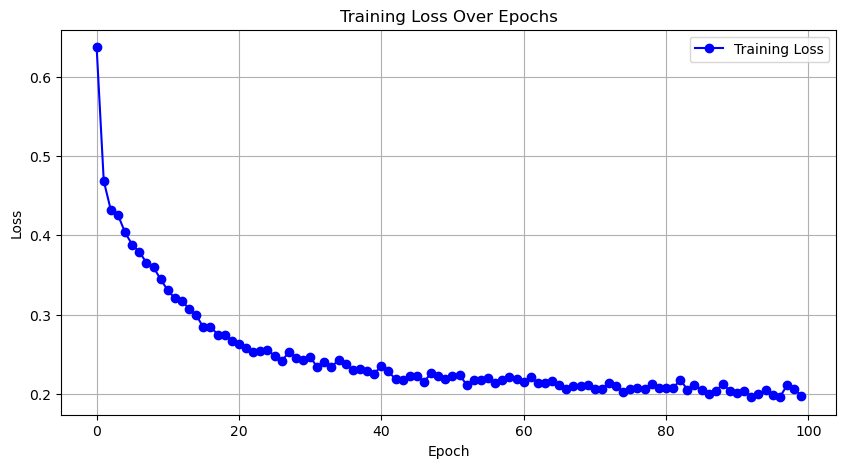

In [7]:
#Plotting our Loss Curve

num_classes=3
def load_model(model_path, device, strict=True):
    model = UNet(in_channels=1, out_channels=num_classes).to(device)
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict, strict=strict)
    model.eval()  # Set to evaluation mode
    return model

def load_loss_values(loss_file_path):
    with open(loss_file_path, 'r') as file:
        loss_values = json.load(file)
    return loss_values

def plot_loss_curve(loss_values):
    # Adjust the loss values to plot 1 - loss_values
    filtered_loss_values = [loss for loss in loss_values if loss >= 0 and loss <= 2]
    
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_loss_values, 'bo-', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# Usage
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = 'C:\\Users\\zladi\\Downloads\\kits23-v0.1.2 - Copy\\kits23-v0.1.2\\kits23\\GPTModel2'
model_path = os.path.join(model_dir, 'unet_epoch_100.pth')  # Update to the last epoch or the specific model file you want to load
loss_file_path = os.path.join(model_dir, 'loss_values.json')

model = load_model(model_path, device)
loss_values = load_loss_values(loss_file_path)
plot_loss_curve(loss_values)


In [6]:
#Data Loader Code. Load Test Dataset (401-457)

class SliceDataset(Dataset):
    def __init__(self, data_folder, cases, max_slices=200, transform=None):
        self.data_folder = Path(data_folder)
        self.transform = transform
        self.all_slices = []
        self.all_segs = []

        for case in cases:
            ct_scan_path = self.data_folder / f"{case}_imaging_filtered.nii.gz"
            seg_mask_path = self.data_folder / f"{case}_segmentation_filtered.nii.gz"

            if ct_scan_path.is_file() and seg_mask_path.is_file():
                ct_scan_volume = nib.load(str(ct_scan_path)).get_fdata()
                seg_mask_volume = nib.load(str(seg_mask_path)).get_fdata()
                
                # Use the minimum number of slices to avoid out-of-bounds indexing
                min_slices = min(ct_scan_volume.shape[0], seg_mask_volume.shape[0])
                slice_indices = np.linspace(0, min_slices - 1, min(max_slices, min_slices), dtype=int)

                for slice_idx in slice_indices:
                    ct_slice = ct_scan_volume[slice_idx, ...]
                    mask_slice = seg_mask_volume[slice_idx, ...]

                    self.all_slices.append(ct_slice)
                    self.all_segs.append(mask_slice)

    def __len__(self):
        return len(self.all_slices)

    def __getitem__(self, idx):
        ct_slice = self.all_slices[idx]
        mask_slice = self.all_segs[idx]

        ct_slice = np.expand_dims(ct_slice, axis=0).astype(np.float32)
        mask_slice = np.expand_dims(mask_slice, axis=0).astype(np.float32)

        if self.transform:
            ct_slice = self.transform(ct_slice)
            mask_slice = self.transform(mask_slice)

        return torch.from_numpy(ct_slice), torch.from_numpy(mask_slice)

data_folder = "C:\\Users\\zladi\\Downloads\\kits23-v0.1.2 - Copy\\kits23-v0.1.2\\kits23\\preprocessandresize - Copy"
cases = ["case_{:05d}".format(i) for i in range(401, 457)]  # Example: Load first 50 cases
dataset = SliceDataset(data_folder, cases)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
print('Dataset size:', len(dataset))
print('Number of slices in dataset:', len(dataset.all_slices))

Dataset size: 2551
Number of slices in dataset: 2551


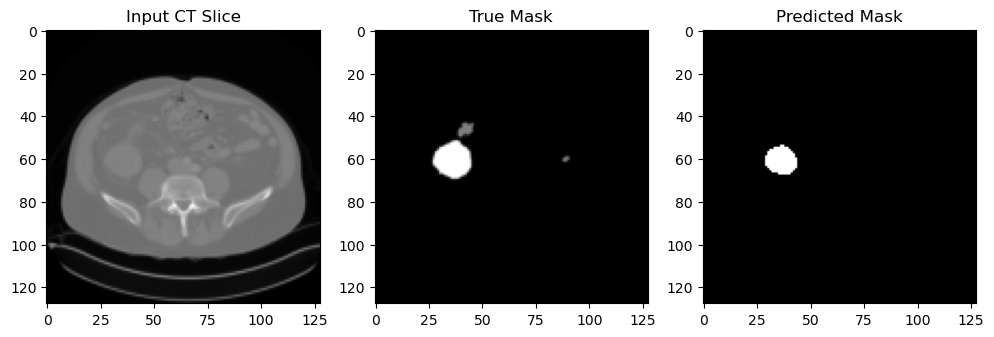

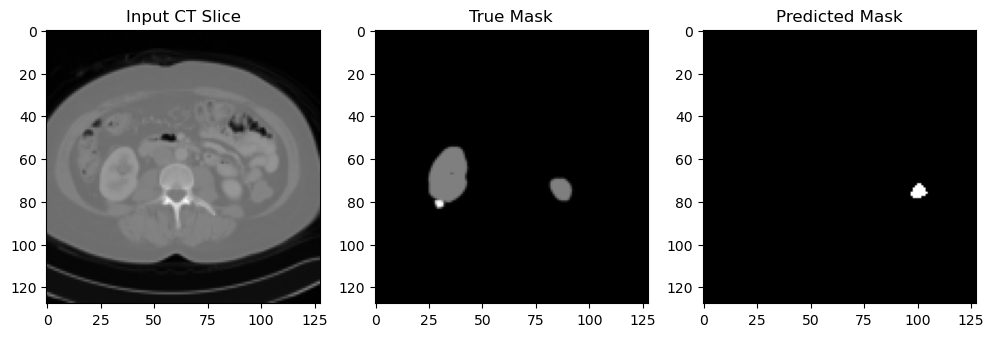

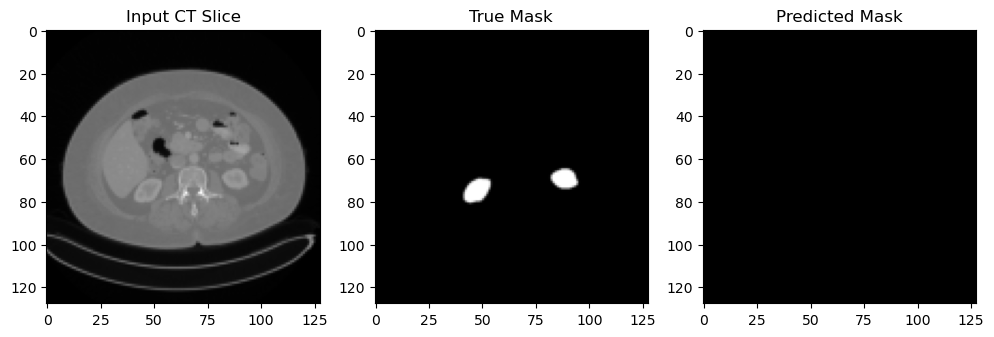

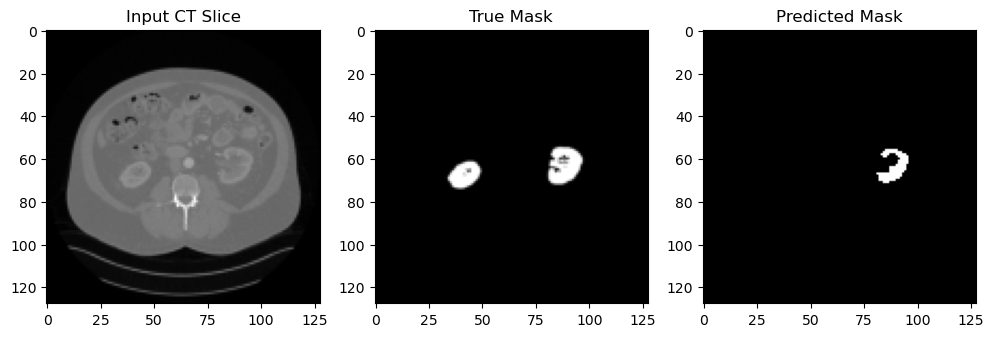

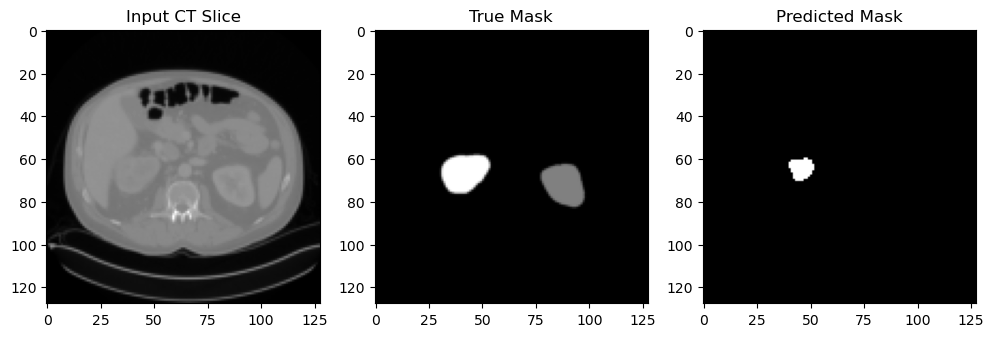

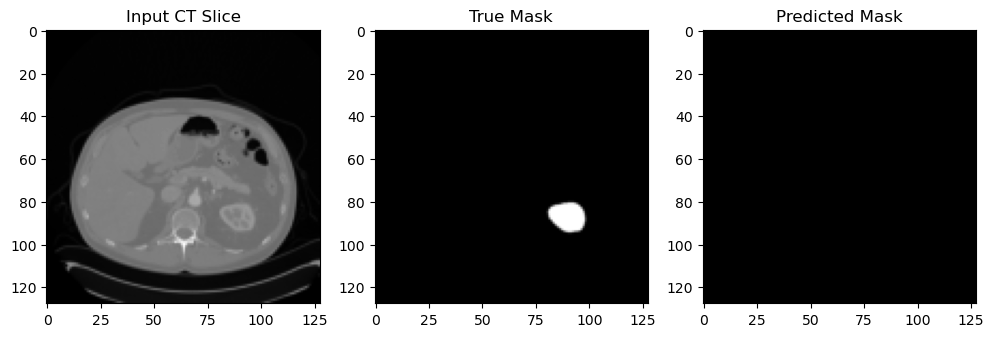

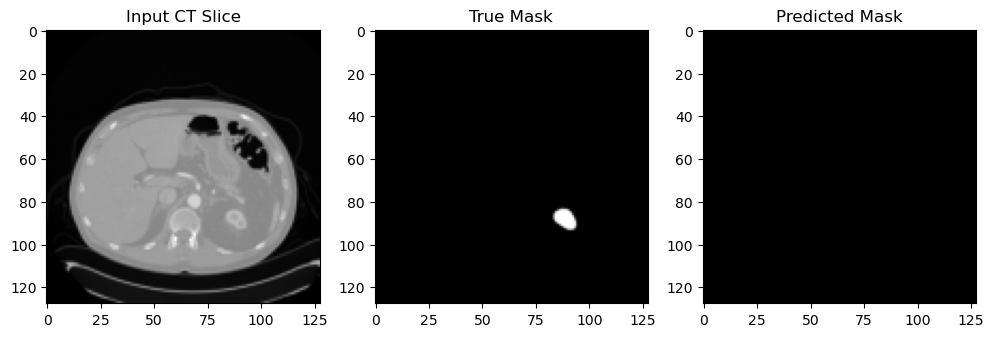

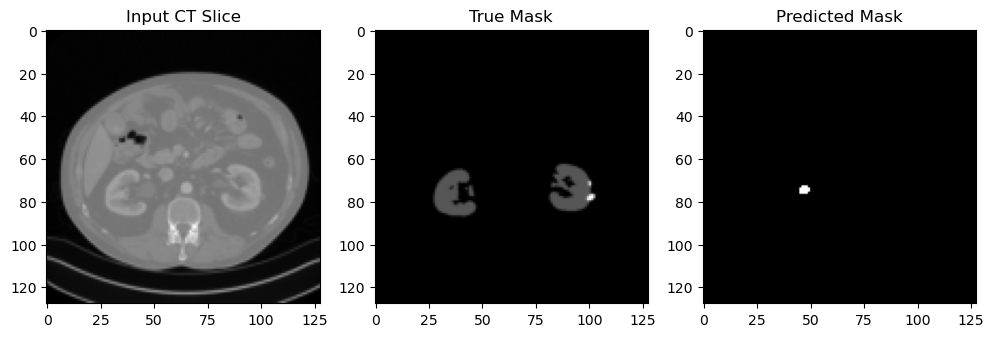

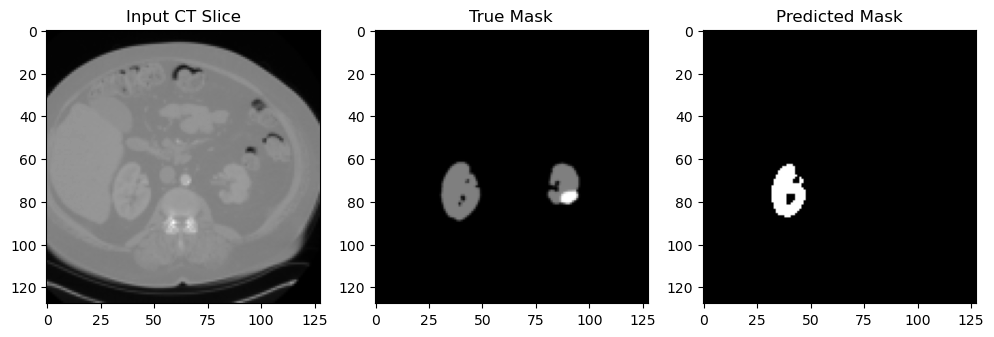

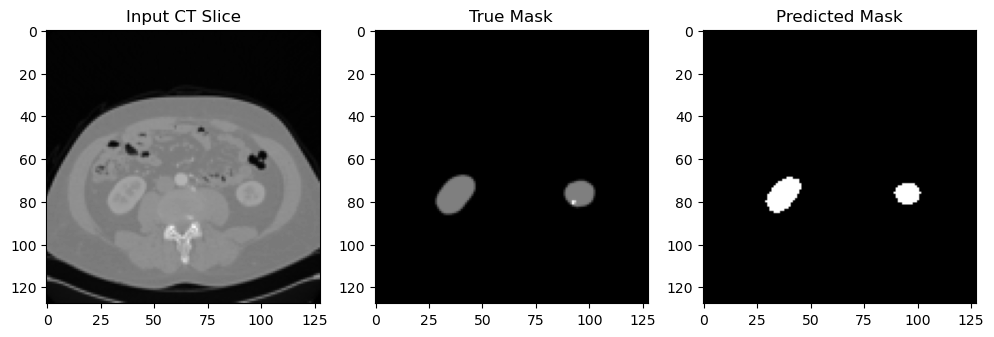

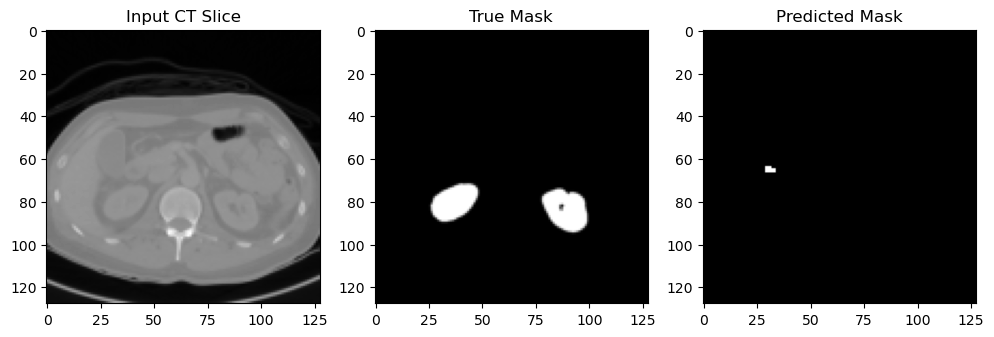

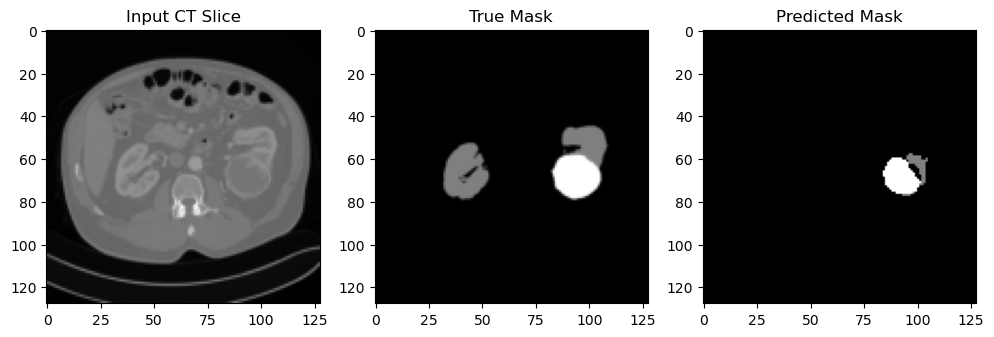

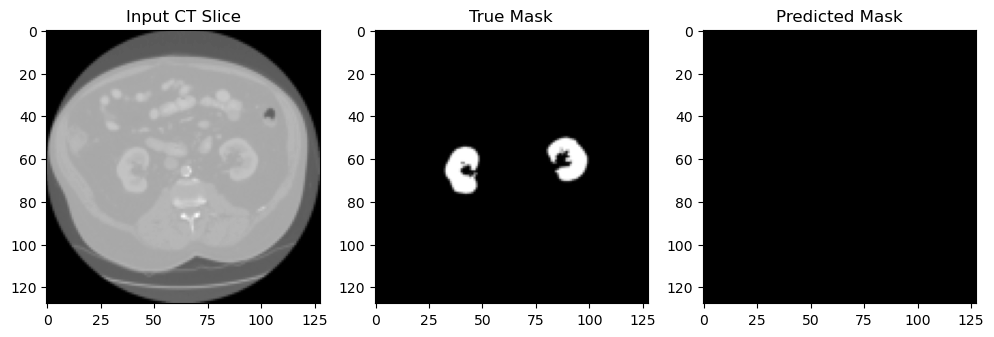

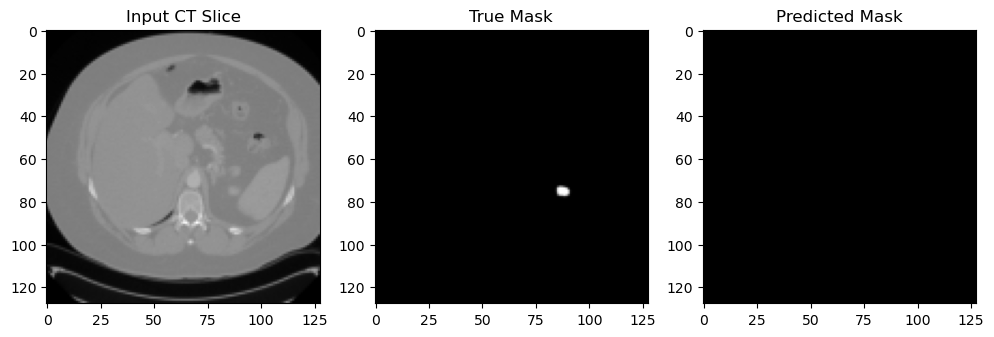

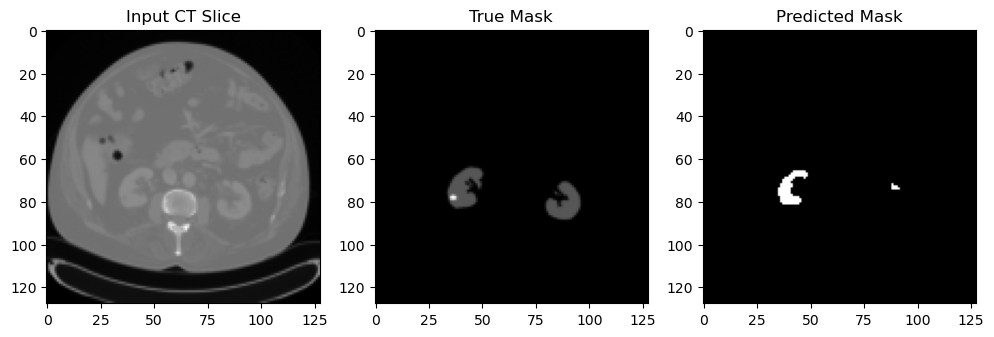

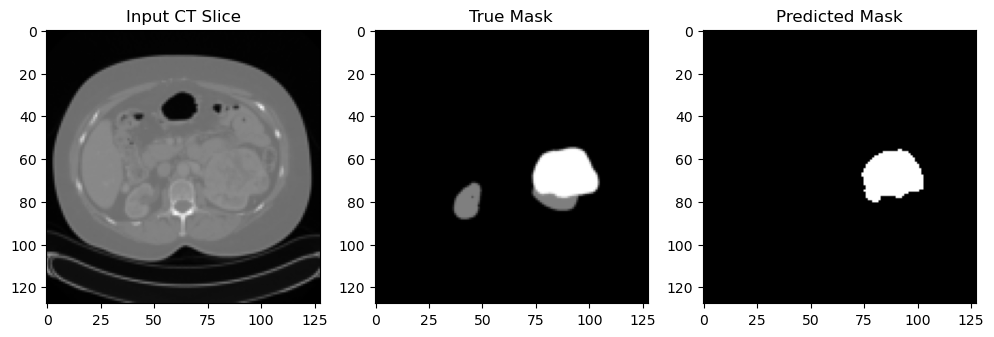

In [15]:
#Model Prediction
#model predict, use dice. Augmented images
def load_model(model_path, device, strict=True):
    model = UNet(in_channels=1, out_channels=num_classes).to(device)
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict, strict=strict)
    model.eval()  # Set to evaluation mode
    return model

def load_loss_values(loss_file_path):
    with open(loss_file_path, 'r') as file:
        loss_values = json.load(file)
    return loss_values

# Assuming your model is already defined, loaded, and set to evaluation mode
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = 'C:\\Users\\zladi\\Downloads\\kits23-v0.1.2 - Copy\\kits23-v0.1.2\\kits23\\GPTModel2'
model_path = os.path.join(model_dir, 'unet_epoch_100.pth')  # Update to the last epoch or the specific model file you want to load
model = load_model(model_path, device)
model.eval()

num_images_to_display = 0.5  # Define how many images to display

with torch.no_grad():  # Disable gradient computation
    # Get a smaller batch from the dataloader or stop iteration early
    for i, (images, masks) in enumerate(dataloader):
        if i >= num_images_to_display:
            break  # Stop after displaying the desired number of examples

        images = images.to(device)  # Move images to the device where the model is
        masks = masks.to(device)  # Move masks to the device (optional if you're not evaluating)

        # Get the model output
        outputs = model(images)
        
        # Convert logits to probabilities and get the class with the maximum probability
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        # Visualize the results for each batch item
        for j in range(len(images)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(images[j][0].cpu(), cmap='gray')
            plt.title('Input CT Slice')
            plt.subplot(1, 3, 2)
            plt.imshow(masks[j][0].cpu(), cmap='gray')
            plt.title('True Mask')
            plt.subplot(1, 3, 3)
            plt.imshow(preds[j].cpu(), cmap='gray')
            plt.title('Predicted Mask')
            plt.show()



In [13]:
#Calculate Mean Dice Score
class DiceMetric(nn.Module):
    def __init__(self, num_classes):
        super(DiceMetric, self).__init__()
        self.num_classes = num_classes

    def forward(self, inputs, targets, smooth=1e-6):
        # Assuming inputs are logits, convert to probabilities using softmax
        inputs = torch.softmax(inputs, dim=1)
        
        dice_scores = []
        for i in range(self.num_classes):
            input_flat = inputs[:, i, :, :].contiguous().view(-1)
            target_flat = (targets == i).float().view(-1)
            
            intersection = (input_flat * target_flat).sum()
            union = input_flat.sum() + target_flat.sum()
            
            # Calculate Dice score for class i
            dice_score = (2. * intersection + smooth) / (union + smooth)
            dice_scores.append(dice_score)
        
        return torch.tensor(dice_scores)  # Return a tensor of dice scores for each class

# Assuming your model is already defined, loaded, and set to evaluation mode
model.eval()
dice_metric = DiceMetric(num_classes=num_classes).to(device)

# Store Dice scores for each class
class_dice_scores = {i: [] for i in range(num_classes)}

with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        
        # Calculate Dice scores using the DiceMetric
        dice_scores = dice_metric(outputs, masks.squeeze(1))
        
        # Store dice scores for each class
        for i in range(num_classes):
            class_dice_scores[i].append(dice_scores[i].item())
    
    # Calculate mean Dice score for each class
    mean_dice_scores = {class_id: sum(scores) / len(scores) for class_id, scores in class_dice_scores.items()}
    print("Mean Dice Scores by Class:", mean_dice_scores)
    overall_dice = sum(mean_dice_scores.values()) / num_classes
    print(f"Overall Mean Dice Score: {overall_dice}")


Mean Dice Scores by Class: {0: 0.985398906096816, 1: 0.5260840693591695, 2: 0.517087274560804}
Overall Mean Dice Score: 0.6761900833389299


In [12]:
#Defining Functions for other validation techniques
import torch

# Convert outputs and targets to binary before performing bitwise operations
import torch

def intersection_over_union(outputs, targets, threshold=0.1):
    """
    Calculate Intersection over Union (IoU) given model outputs and ground truth targets.
    Args:
    - outputs: Tensor containing model predictions (logits or probabilities).
    - targets: Tensor containing ground truth binary labels.
    - threshold: Threshold to convert predictions into binary (default 0.5).
    """
    # Convert model outputs to binary predictions using a threshold
    outputs = torch.sigmoid(outputs) > threshold  # Convert to binary with threshold
    targets = targets > threshold  # Ensure targets are also binary

    # Calculate intersection and union
    intersection = (outputs & targets).sum().float()  # True positives
    union = (outputs | targets).sum().float()  # All predicted positives and actual positives

    # Avoid division by zero and ensure numerical stability
    iou = (intersection / (union + 1e-8)).item()  # Epsilon to avoid division by zero
    
    return iou


def pixel_accuracy(outputs, targets):
    outputs = torch.sigmoid(outputs) > 0.5
    targets = targets > 0.5
    correct = (outputs == targets).sum()
    total = outputs.numel()
    accuracy = (correct / total).item()
    return accuracy

def mean_intersection_over_union(outputs, targets):
    outputs = torch.sigmoid(outputs) > 0.1
    targets = targets > 0.1
    batch_size = outputs.size(0)
    iou = 0
    for i in range(batch_size):
        iou += intersection_over_union(outputs[i], targets[i])
    miou = iou / batch_size
    return miou

def precision(outputs, targets):
    """
    Calculate precision given model outputs and ground truth targets.
    Args:
    - outputs: Tensor containing model predictions (logits or probabilities).
    - targets: Tensor containing ground truth binary labels.
    """
    # Convert model outputs to binary predictions using a threshold
    outputs = torch.sigmoid(outputs) > 0.1  # Convert to binary
    targets = targets > 0.1  # Ensure targets are also binary

    # Calculate true positives and predicted positives
    true_positives = (outputs & targets).sum().float()  # Ensure it's a float
    predicted_positives = outputs.sum().float()  # Ensure it's a float

    # Avoid division by zero and maintain numerical stability
    precision_val = (true_positives / (predicted_positives + 1e-8)).item()  # Add small epsilon to avoid division by zero
    
    return precision_val

import torch

def recall(predictions, targets, threshold=0.1):
    """
    Calculate the sensitivity (recall) given predictions and targets.
    Args:
    - predictions: tensor of model outputs (probabilities or logits)
    - targets: tensor of ground truth labels
    - threshold: threshold to convert predictions into binary (default 0.5)
    """
    # Ensure binary predictions (threshold-based)
    predicted_labels = (predictions >= threshold).long()

    # Calculate true positives and false negatives
    true_positives = ((predicted_labels == 1) & (targets == 1)).sum().item()
    false_negatives = ((predicted_labels == 0) & (targets == 1)).sum().item()
    total_positives = true_positives + false_negatives  # All actual positives

    # Handle edge cases
    if total_positives == 0:  # If there are no actual positives, sensitivity is undefined
        return float('nan')  # You might choose to return NaN or another value
    
    # Compute sensitivity
    sensitivity_value = true_positives / total_positives
    
    return sensitivity_value


def f1_score(outputs, targets):
    """
    Calculate the F1 score given model outputs and ground truth targets.
    
    Args:
    - outputs: Tensor containing model predictions (logits or probabilities).
    - targets: Tensor containing ground truth binary labels.
    
    Returns:
    - f1: Calculated F1 score as a float.
    """
    prec = precision(outputs, targets)  # Assumes precision function is defined and working
    rec = recall(outputs, targets)  # Assumes recall function is defined and working
    
    # Handling case when both precision and recall are zero
    if prec + rec == 0:
        return 0.0  # Return F1 score of 0 if both precision and recall are zero
    
    # Calculating F1 score
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)  # Use a small epsilon to avoid division by zero
    return f1


def specificity(predictions, targets, threshold=0.2):
    """
    Calculate the specificity given predictions and targets.
    Args:
    - predictions: tensor of model outputs (probabilities or logits)
    - targets: tensor of ground truth labels
    - threshold: threshold to convert predictions into binary (default 0.5)
    """
    # Ensure binary predictions (threshold-based)
    predicted_labels = (predictions >= threshold).long()

    # Calculate true negatives and false positives
    true_negatives = ((predicted_labels == 0) & (targets == 0)).sum().item()
    false_positives = ((predicted_labels == 1) & (targets == 0)).sum().item()
    total_negatives = true_negatives + false_positives  # All actual negatives

    # Handle edge cases
    if total_negatives == 0:  # If there are no actual negatives, specificity is undefined
        return float('nan')  # You might choose to return NaN or another value
    
    # Compute specificity
    specificity_value = true_negatives / total_negatives
    
    return specificity_value

In [13]:
#Calculating other validation Techniques

model.eval()  # Ensure model is in evaluation mode
iou_values = []
accuracy_values = []
miou_values = []
precision_values = []
recall_values = []
f1_values = []
specificity_values = []

for images, masks in dataloader:
    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images)
    
    # Calculate metrics for each batch
    iou_values.append(intersection_over_union(outputs, masks))
    accuracy_values.append(pixel_accuracy(outputs, masks))
    miou_values.append(mean_intersection_over_union(outputs, masks))
    precision_values.append(precision(outputs, masks))
    recall_values.append(recall(outputs, masks))
    f1_values.append(f1_score(outputs, masks))
    specificity_values.append(specificity(outputs, masks))

# Calculate average metrics over all batches
iou_avg = sum(iou_values) / len(iou_values)
accuracy_avg = sum(accuracy_values) / len(accuracy_values)
miou_avg = sum(miou_values) / len(miou_values)
precision_avg = sum(precision_values) / len(precision_values)
recall_avg = sum(recall_values) / len(recall_values)
f1_avg = sum(f1_values) / len(f1_values)
specificity_avg = sum(specificity_values) / len(specificity_values)

print("Intersection over Union (IoU):", iou_avg)
print("Pixel Accuracy:", accuracy_avg)
print("Mean Intersection over Union (mIoU):", miou_avg)
print("Precision:", precision_avg)
print("Recall (Sensitivity):", recall_avg)
print("F1 Score:", f1_avg)
print("Specificity:", specificity_avg)

Intersection over Union (IoU): 0.03299660088960081
Pixel Accuracy: 0.6580346018075943
Mean Intersection over Union (mIoU): 0.029834205763680594
Precision: 0.034838224051054564
Recall (Sensitivity): 0.34889662556871537
F1 Score: 0.06315154911105346
Specificity: 0.6665921727604986


In [14]:
#Plotting the "new" model
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'
# Replace with your model
model = UNet(in_channels=1, out_channels=3).to(device)

# Dummy input to generate the computational graph
x = torch.rand(1, 1, 128, 128).to(device)  # Adjust dimensions as needed

# Create a graph and save it as an image
graph = torchviz.make_dot(model(x))  # No parameters to reduce complexity
graph.format = 'png'
graph.render('simple_model_plot2')

'simple_model_plot2.png'